# Crypto-Assets Cointegration Matrix

### Modules

In [266]:
import numpy as np
import pandas as pd
import math

import statsmodels
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as stat
import statsmodels.tsa.stattools as ts

import matplotlib.pyplot as plt
from datetime import datetime, date

import seaborn as sb
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

### Import Data

In [267]:
# Import Data
assets = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'LUNAUSDT', 'SOLUSDT', 'ADAUSDT', 'DOTUSDT', 'AVAXUSDT', 'DOGEUSDT', '1000SHIBUSDT', 'MATICUSDT', 'ATOMUSDT', 'LTCUSDT', 'NEARUSDT', 'TRXUSDT', 'LINKUSDT', 'BCHUSDT', 'ALGOUSDT', 'XLMUSDT', 'UNIUSDT', 'AXSUSDT', 'MANAUSDT', 'ETCUSDT', 'XMRUSDT', 'EGLDUSDT', 'SANDUSDT', 'FILUSDT', 'FTMUSDT', 'EOSUSDT', 'ZECUSDT', 'AAVEUSDT', 'COMPUSDT', 'MKRUSDT', 'YFIUSDT', 'YFIIUSDT']
#assets = ['BTCUSDT', 'ETHUSDT', 'ZECUSDT', 'XMRUSDT', 'LTCUSDT', 'ETCUSDT', 'YFIUSDT', 'YFIIUSDT', 'XRPUSDT', 'ADAUSDT', 'ZENUSDT', 'DASHUSDT']
data = {}
prices_1h = {}

for asset in assets:
    data[asset] = pd.read_csv('./{}_1h.csv'.format(asset), index_col=0)
    data[asset].iloc[:,0] = pd.to_datetime(data[asset].iloc[:,0], unit='ms')
    prices_1h[asset] = pd.DataFrame({'date': data[asset].iloc[:,0], 'price': data[asset].iloc[:,3]})
    prices_1h[asset]['log_price'] = prices_1h[asset]['price'].apply(lambda x: math.log(x))


### Functions

In [268]:
# Functions
def engle_granger_coint(A, B):
    result = stat.OLS(A, B).fit()
    a = ts.adfuller(result.resid)
    pvalue = a[1]
    return pvalue, result.params[0]


def johansen_coint(A, B):
    df = pd.DataFrame({'x': A, 'y': B})
    jres = coint_johansen(df, 0, 1)
    return jres.max_eig_stat[0], jres.max_eig_stat_crit_vals[0], jres.evec[0]


def cointegration(coint_type, confidence_interval, data_A, data_B):
    
    # Make data same size
    length_A = len(data_A)
    length_B = len(data_B)
    if length_A > length_B:
        data_A = data_A[(length_A-length_B):]
    elif length_B > length_A:
        data_B = data_B[(length_B-length_A):]
    
    data_A = list(data_A)
    data_B = list(data_B)
    
    
    if coint_type == 'engle-granger':
        pvalue, beta = engle_granger_coint(data_A, data_B)
        cointegrated = pvalue <= 1 - confidence_interval
        return cointegrated, pvalue, beta

    elif coint_type == 'johansen':
        max_eig_value, max_eig_crit_val, eigenvectors = johansen_coint(data_A, data_B)
        if confidence_interval == 0.9:
            cointegrated = max_eig_value > max_eig_crit_val[0]
        elif confidence_interval == 0.95:
            cointegrated = max_eig_value > max_eig_crit_val[1]
        elif confidence_interval == 0.99:
            cointegrated = max_eig_value > max_eig_crit_val[2]
        else:
            raise Exception('Wrong convidence interval')
        return cointegrated, max_eig_value, eigenvectors
    
    else:
        raise Exception('Wrong Cointegration Type')

        
def rolling_cointegration(coint_type, confidence_interval, data_A, data_B, lookback_window):
    
    dates = list(data_A['date'])

    # Make data same size
    length_A = len(data_A)
    length_B = len(data_B)
    if length_A > length_B:
        data_A = data_A[(length_A-length_B):]
    elif length_B > length_A:
        data_B = data_B[(length_B-length_A):]

    rolling_coint = {'date':[], 'cointegrated': [], 'stat': [], 'beta': []}
    
    # Rolling Cointegration
    for i in range(len(dates)-1, 0, -1):
        if i - lookback_window >= 0:
            data_window_A = list(data_A['price'].iloc[i - lookback_window:i])
            data_window_B = list(data_B['price'].iloc[i - lookback_window:i])
            cointegrated, stat, beta = cointegration(coint_type, confidence_interval, data_window_A, data_window_B)
            
            rolling_coint['date'].append(dates[i])
            rolling_coint['cointegrated'].append(cointegrated)
            rolling_coint['stat'].append(stat)
            rolling_coint['beta'].append(beta)

    return rolling_coint


def calculate_consecutive_candles(rolling_cointegration):
    
    candles_counter = 0
    cointegrated = False
    beta = []
    start_date = ''
    end_date = ''
    
    rolling_cointegration = pd.DataFrame(rolling_cointegration)
    consecutive_candles = {'start_date': [], 'end_date': [], 'nbr_of_candles': [], 'beta_median': []}
    
    for i in range(0, len(rolling_cointegration)):
        row = rolling_cointegration.iloc[i]
        if not cointegrated and row['cointegrated']:
            cointegrated = True
            end_date = row['date']
            beta.append(row['beta'])
        elif cointegrated and row['cointegrated']:
            candles_counter += 1
            beta.append(row['beta'])
        elif cointegrated and not row['cointegrated']:
            if candles_counter > 0:
                start_date = row['date']
                beta_median = pd.Series(beta).median()

                consecutive_candles['start_date'].append(start_date)
                consecutive_candles['end_date'].append(end_date)
                consecutive_candles['nbr_of_candles'].append(candles_counter)
                consecutive_candles['beta_median'].append(beta_median) #Careful with this if using johansen
        
            # Reset variables
            candles_counter = 0
            cointegrated = False
            beta = []
            start_date = ''
            end_date = ''
            
        else:
            pass
    
    return consecutive_candles



### Isolated Pair Rolling Cointegration

In [ ]:
start_date = '2021-01-01 00:00:00'
end_date = '2022-03-15 00:00:00'
lookback_window = 24 * 8
coint_type = 'engle-granger'
confidence_interval = 0.95

pairs = [['ZECUSDT', 'XMRUSDT'], ['LTCUSDT', 'ETCUSDT'], ['YFIUSDT', 'YFIIUSDT'], ['XRPUSDT', 'ADAUSDT']]

rolling_coint = rolling_cointegration(coint_type, confidence_interval, data_A, data_B, lookback_window)

### Cointegration Matrix

In [269]:
start_date = '2021-01-01 00:00:00'
end_date = '2021-08-15 00:00:00'
lookback_window = 24 * 10
coint_type = 'engle-granger'
confidence_interval = 0.95

counter = 0
total_pairs = len(assets) * len(assets) #total_pairs = int((len(selected_assets) * len(selected_assets) - len(selected_assets)) / 2)
rolling_coint_matrix = pd.DataFrame(index=assets, columns=assets)
coint_matrix = pd.DataFrame(index=assets, columns=assets)
rolling_beta_matrix = pd.DataFrame(index=assets, columns=assets)
beta_matrix = pd.DataFrame(index=assets, columns=assets)
for i in range(0, len(coint_matrix)):
    data_A = prices_1h[assets[i]][prices_1h[assets[i]]['date'] > start_date]
    data_A = data_A[data_A['date'] < end_date]
    data_A['price'] = data_A['log_price']
    for j in range(0, len(coint_matrix)):
        counter += 1
        data_B = prices_1h[assets[j]][prices_1h[assets[j]]['date'] > start_date]
        data_B = data_B[data_B['date'] < end_date]
        data_B['price'] = data_B['log_price']
        print("Calculating pair {} of {}".format(counter, total_pairs))
        rolling_coint = rolling_cointegration(coint_type, confidence_interval, data_A, data_B, lookback_window)
        rolling_coint_matrix[assets[i]][assets[j]] = np.median(rolling_coint['stat'])
        coint_matrix[assets[i]][assets[j]] = rolling_coint['stat']
        rolling_beta_matrix[assets[i]][assets[j]] = np.median(rolling_coint['beta'])
        beta_matrix[assets[i]][assets[j]] = rolling_coint['beta']

rolling_coint_matrix = rolling_coint_matrix.astype(float).fillna(1)
rolling_beta_matrix = rolling_beta_matrix.astype(float)

coint_matrix.to_csv('rolling_coint_jan_2021_aout_2021.csv')

Calculating pair 1 of 1296
Calculating pair 2 of 1296
Calculating pair 3 of 1296
Calculating pair 4 of 1296
Calculating pair 5 of 1296


ValueError: zero-size array to reduction operation maximum which has no identity

<AxesSubplot:title={'center':'Rolling Beta Matrix'}>

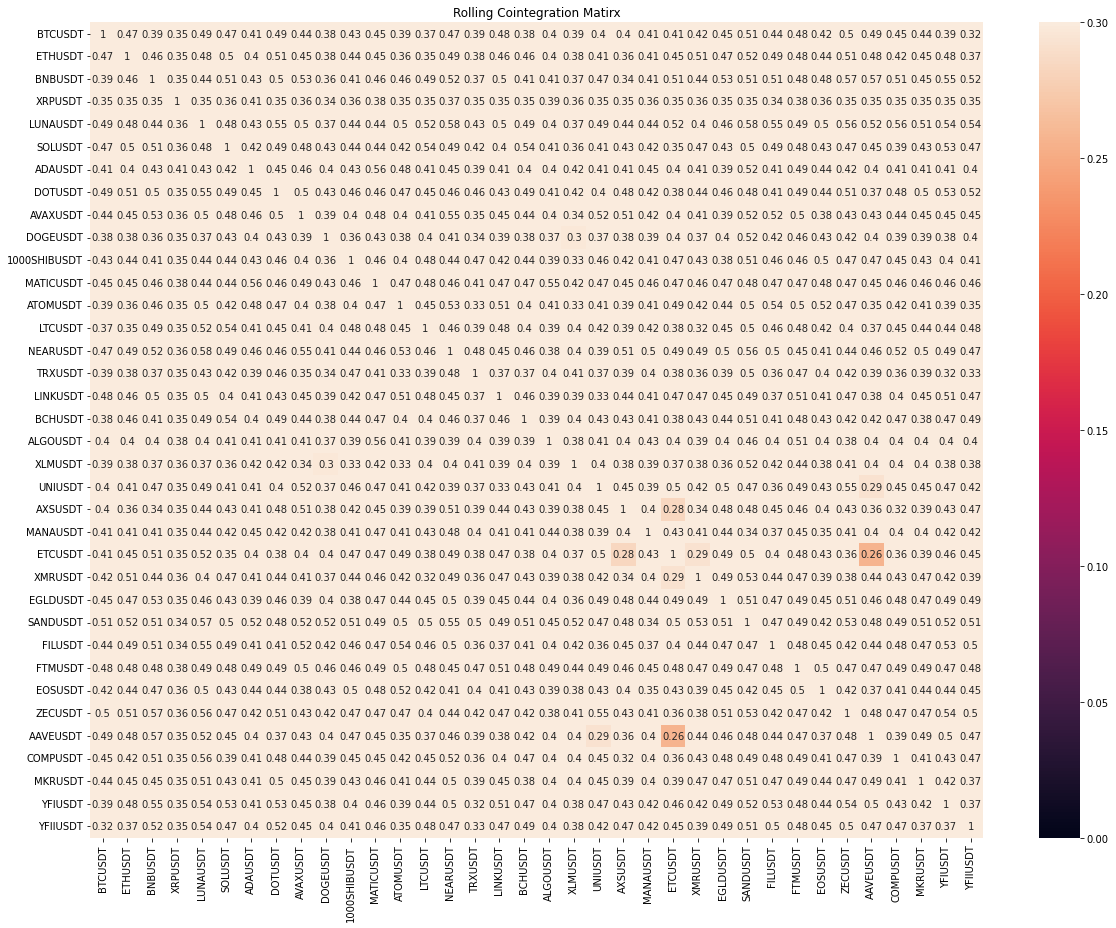

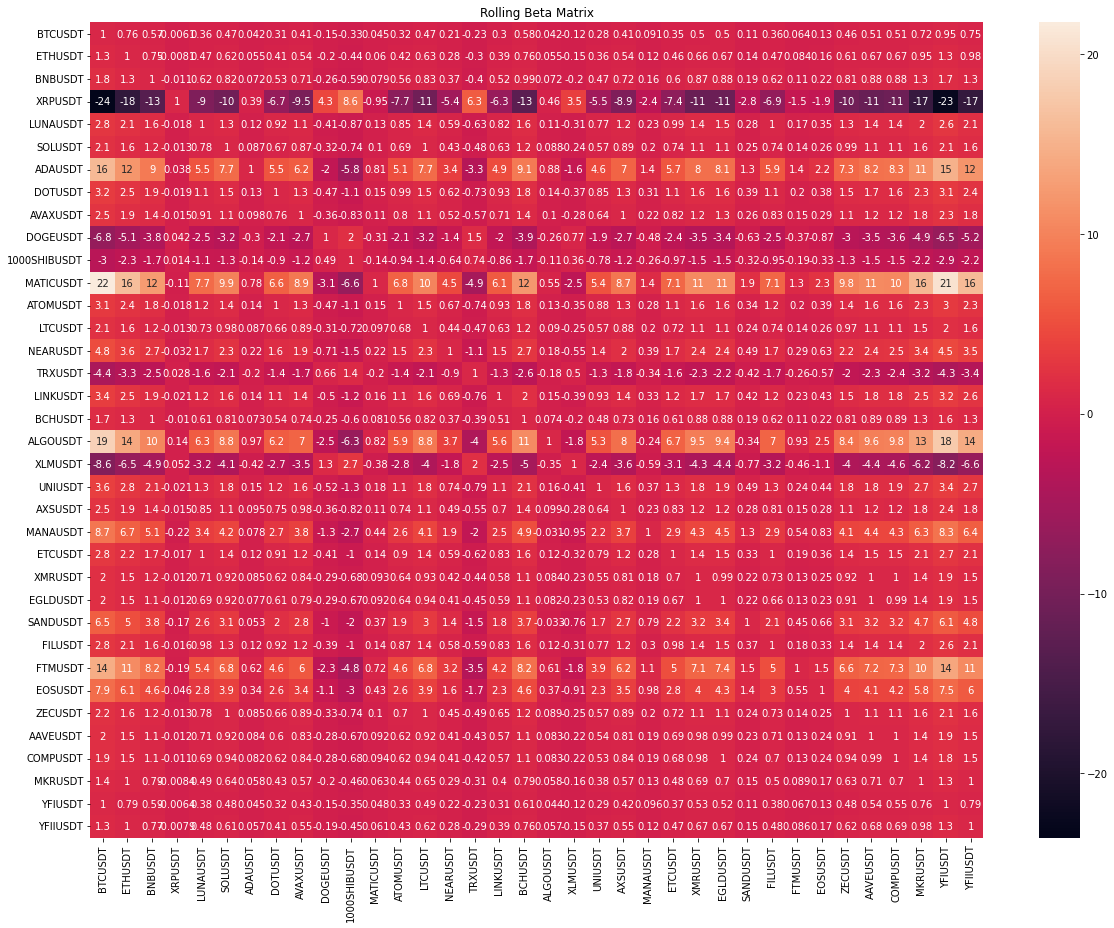

In [251]:
# Show
plt.figure(figsize=(20,15))
plt.title('Rolling Cointegration Matirx')
sb.heatmap(rolling_coint_matrix, annot=True, vmin=0, vmax=0.3)

# Show
plt.figure(figsize=(20,15))
plt.title('Rolling Beta Matrix')
sb.heatmap(rolling_beta_matrix, annot=True)

ValueError: x and y must have same first dimension, but have shapes (12359,) and (4847,)

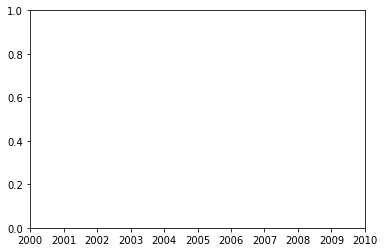

In [264]:
plt.plot(dates, coint_matrix['ETCUSDT']['AAVEUSDT'])

In [265]:
prices_1h['AAVEUSDT'][prices_1h['AAVEUSDT']['date'] >= start_date]

,date,price,log_price
203,2021-08-15 00:00:00,410.24,6.016742
204,2021-08-15 01:00:00,412.40,6.021994
205,2021-08-15 02:00:00,413.15,6.023811
206,2021-08-15 03:00:00,409.00,6.013715
207,2021-08-15 04:00:00,406.37,6.007264
...,...,...,...
291,2022-03-15 00:00:00,117.58,4.767119
292,2022-03-15 01:00:00,115.86,4.752383
293,2022-03-15 02:00:00,115.90,4.752728
294,2022-03-15 03:00:00,115.15,4.746236


ValueError: x and y must have same first dimension, but have shapes (1415,) and (4847,)

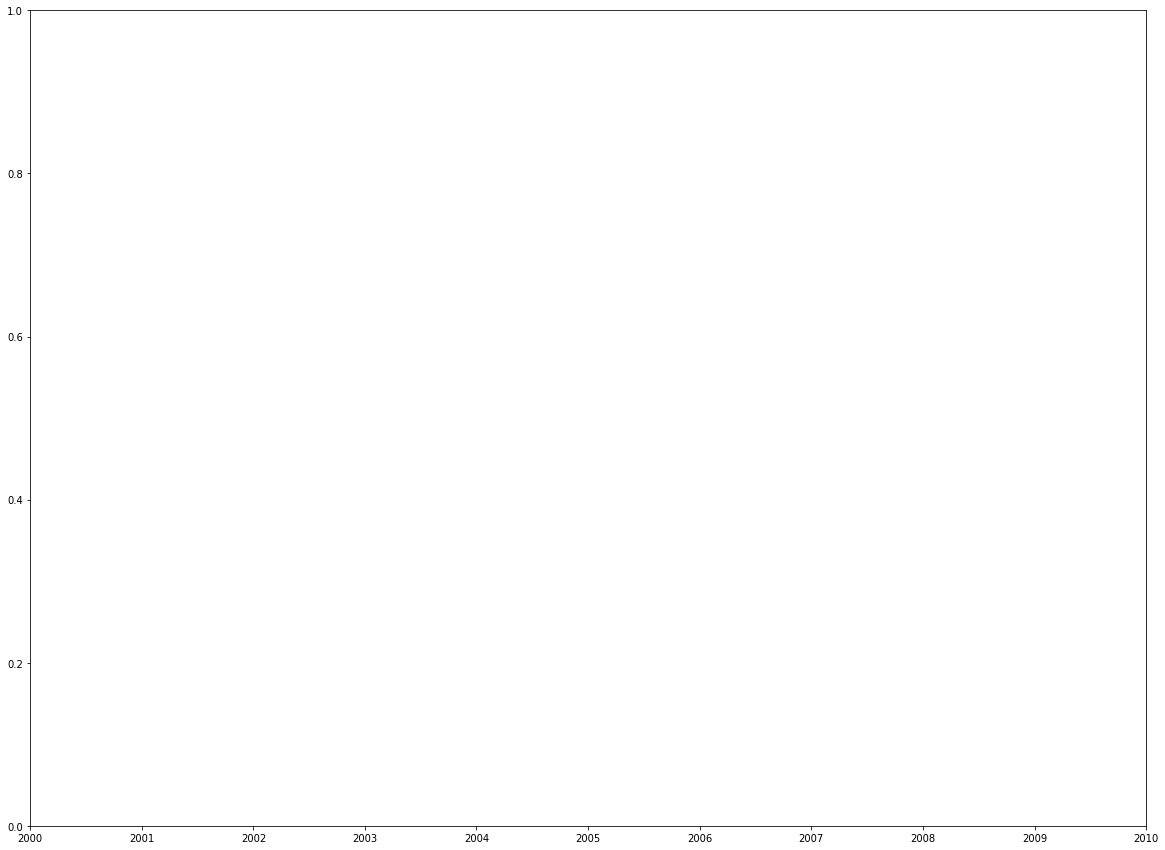

In [252]:
plt.figure(figsize=(20,15))
plt.plot(dates[len(dates)-len(coint_matrix['ETCUSDT']['AAVEUSDT']):], coint_matrix['ETCUSDT']['AAVEUSDT'])
plt.axhline(y=0.05, color='r')

In [199]:
df = prices_1h[assets[i]][prices_1h[assets[i]]['date'] > start_date]
df = df[df['date'] < end_date]
dates = df['date']

In [203]:
len(coint_matrix['UNIUSDT']['NEARUSDT'])

1223

In [207]:
len(dates[len(dates)-len(coint_matrix['UNIUSDT']['NEARUSDT']):])

1223

In [221]:
np.median(coint_matrix[asset_a][asset_b])

0.4167999090217893

BTCUSDT/YFIUSDT
ZECUSDT/XMRUSDT
XMRUSDT/ZECUSDT
XMRUSDT/LTCUSDT
LTCUSDT/XMRUSDT
YFIUSDT/BTCUSDT


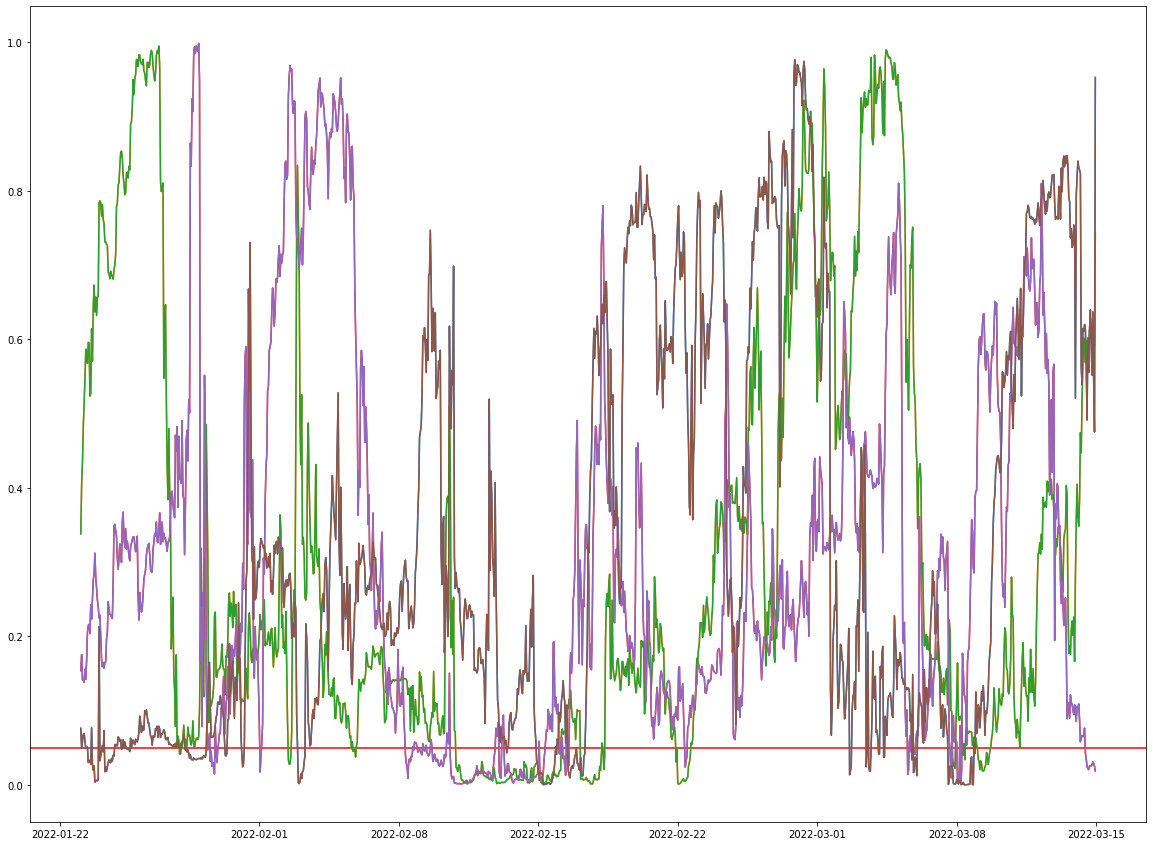

In [241]:
df = prices_1h[assets[0]][prices_1h[assets[0]]['date'] > start_date]
df = df[df['date'] < end_date]
dates = df['date']

plt.figure(figsize=(20,15))
plt.axhline(y=0.05, color='r')

for asset_a in coint_matrix.index:
    for asset_b in coint_matrix.columns:
        if(np.median(coint_matrix[asset_a][asset_b]) < 0.25):
            print('{}/{}'.format(asset_a,asset_b))
            plt.plot(dates[len(dates)-len(coint_matrix[asset_a][asset_b]):], coint_matrix[asset_a][asset_b])

        

In [216]:
coint_matrix.columns

Index(['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'XRPUSDT', 'LUNAUSDT', 'SOLUSDT',
       'ADAUSDT', 'DOTUSDT', 'AVAXUSDT', 'DOGEUSDT', '1000SHIBUSDT',
       'MATICUSDT', 'ATOMUSDT', 'LTCUSDT', 'NEARUSDT', 'TRXUSDT', 'LINKUSDT',
       'BCHUSDT', 'ALGOUSDT', 'XLMUSDT', 'UNIUSDT', 'AXSUSDT', 'MANAUSDT',
       'ETCUSDT', 'XMRUSDT', 'EGLDUSDT', 'SANDUSDT', 'FILUSDT', 'FTMUSDT',
       'EOSUSDT', 'ZECUSDT', 'AAVEUSDT', 'COMPUSDT', 'MKRUSDT'],
      dtype='object')